iter:50 training loss: 0.04597635194659233, val loss: 0.04458083212375641
iter:100 training loss: 0.03309397026896477, val loss: 0.033822380006313324
iter:150 training loss: 0.02329343929886818, val loss: 0.033848948776721954
iter:200 training loss: 0.01869930699467659, val loss: 0.02010943926870823
iter:250 training loss: 0.014419680461287498, val loss: 0.01634705811738968
iter:300 training loss: 0.018321340903639793, val loss: 0.010925576090812683
iter:350 training loss: 0.015228656120598316, val loss: 0.010194974951446056
iter:400 training loss: 0.011817569844424725, val loss: 0.012306924909353256
iter:450 training loss: 0.011677892878651619, val loss: 0.009619541466236115
iter:500 training loss: 0.0058889370411634445, val loss: 0.009237623773515224
iter:550 training loss: 0.007988524623215199, val loss: 0.008261196315288544
iter:600 training loss: 0.010592539794743061, val loss: 0.010451322421431541
iter:650 training loss: 0.010208488442003727, val loss: 0.007155140396207571
iter:7

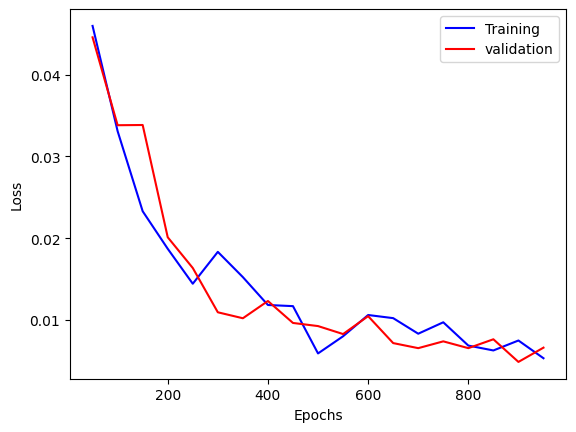

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from utils import *


def sample_data(split = 'train'):
    if split == 'train':
        data =  training_dataset
    else:
        data = validation_dataset
    
    ix = torch.randperm(data.shape[0])[:batch_size]
    
    return data[ix]

learning_rate = 0.01
max_iters = 1000
batch_size = 32

iters = []
loss_value = []
val_loss_value = []

dataset = torch.load("data/hidden.pt")
dataset_size = dataset.shape[0]
training_dataset = dataset[:int(dataset_size*0.5)]
validation_dataset = dataset[int(dataset_size*0.5):]
model = SAE(SAE_Config())

LOAD_MODEL = False
PATH = "models/basic_linear_0.99.bin"
if LOAD_MODEL:
    model = SAE(SAE_Config())
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X= sample_data()
        _, loss,_ = model(X)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V = sample_data(split= 'val')
                _, val_loss, _ = model(X_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()



        






In [11]:


_, _, hidden = model(training_dataset)

In [12]:
(hidden>0).sum(-1).float().mean()

tensor(1.1438)

In [4]:
(hidden>0.1).sum(0)

tensor([12690,     0,     3,     0,     1,     0, 10726,     0,     0,     0,
            0,   109,     0,     0,     0, 10990,     0,     2,     0,     0,
        12853,     0,     0, 13020,     1,     0, 13240,     0, 12936,     0,
            0, 12741,     0,     3,     0, 13210,     1,     0,     0,     0,
        12892,     1,     0,     0,     3, 13517, 12630,     0,  6702,     0])

In [131]:
hidden[5]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1026, 0.0000, 0.0000, 0.0000, 0.0000, 0.0928, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0766, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0009], grad_fn=<SelectBackward0>)

In [135]:
hidden.max()

tensor(0.5216, grad_fn=<MaxBackward1>)

In [9]:
sp = SuperpositionModel(SuperPositionConfig())
PATH = "models/superpositon.pt"
sp.load_state_dict(torch.load(PATH))
sp.eval()

SuperpositionModel(
  (encoder): Linear(in_features=20, out_features=5, bias=False)
  (decoder): Linear(in_features=5, out_features=20, bias=True)
  (relu): ReLU()
)

In [7]:
original_data  = torch.load("data/original.pt")

torch.Size([327680, 5])